# Numerical Bifurcation Analysis of Large Scale Systems: HW4

## 1) Plotting the bifurcation diagram of the first three bifurcations

In [1]:
%matplotlib inline
from nbaolss import *
import numpy as np
import scipy
from scipy.linalg import eig
import matplotlib.pyplot as plt

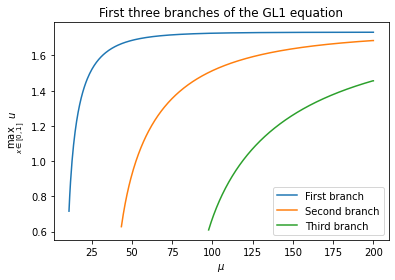

In [6]:
num_branches = 3
size = 100

us, mus = init(num_branches, size)
mu_end = 200
steps = 400
max_vals = np.zeros(steps)

labels = ['First branch', 'Second branch', 'Third branch']
for branch in range(0, num_branches):
    mu_pts = np.linspace(mus[branch], mu_end, steps)
    data = cont(mus[branch], us[branch, :], mu_end, steps)
    
    for step in range(0, steps):
        max_vals[step] = np.amax(data[step]) # Take the global extremum
        
    plt.plot(mu_pts, max_vals, label=labels[branch])
    
plt.xlabel('$\mu$')
plt.ylabel('$\max_{x \in [0,1]} \: \:u$')
plt.title('First three branches of the GL1 equation')
plt.legend()

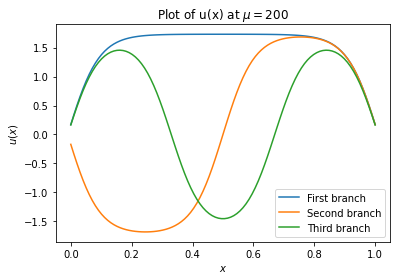

In [3]:
num_branches = 3
size = 100
grid_pts = np.linspace(0, 1, size)

us, mus = init(num_branches, size)
mu_end = 200
steps = 200

labels = ['First branch', 'Second branch', 'Third branch']
for branch in range(0, num_branches):
    data = cont(mus[branch], us[branch, :], mu_end, steps)        
    plt.plot(grid_pts, data[-1], label=labels[branch])
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.title('Plot of u(x) at $\mu=200$')
plt.legend()

## 2) Adding a forcing term to the linearized equation
Now we are going to add the forcing term $0.01\sin (\pi x )$ to the steady state equation, and for now consider the linearized version. We say that this linearization is reasonable if $u^3/3$ is less than 10% of $u$, so to find these bounds we simply solve $u^3/3 = 0.1u$ which implies that $|u| < \sqrt{0.3}$ and we added these values to the plot.

In this case, we have that the forcing function is equal to an eigenfunction, so if $u$ is small then $u^3/3$ can be disregarded, then we get the eigenvalue problem with a forcing term. Previously, we only had the trivial solution for small $\mu$'s, but now due to the forcing we have a nontrivial solution for all $\mu$.

For the nonlinear case, we expect that the solution is similar as long as $u$ is between the max and min lines.

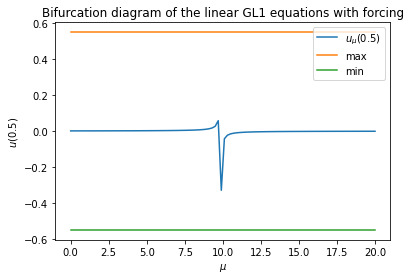

In [4]:
def forcing_lin_GL1(size, mu):
    diag_values = mu * np.ones(size)
    return linGL1(size) + scipy.sparse.diags(diag_values, 0, format="csr") 

def rhs_vec_lin(size):
    return np.sin(np.pi * np.linspace(0, 1, size)) / 100

size = 100
steps = 100
mus = np.linspace(0, 20, steps)
u05 = np.zeros(steps)

for step in range(steps):
    sol = scipy.sparse.linalg.spsolve(-forcing_lin_GL1(size, mus[step]), rhs_vec_lin(size))
    u05[step] = sol[50] # (0 + 100) / 2 = 50
    
plt.plot(mus, u05, label='$u_\mu(0.5)$')
plt.plot(mus, np.sqrt(0.3) * np.ones(steps), label='max')
plt.plot(mus, -np.sqrt(0.3) * np.ones(steps), label='min')

plt.xlabel('$\mu$')
plt.ylabel('$u(0.5)$')
plt.title('Bifurcation diagram of the linear GL1 equations with forcing')
plt.legend()

## 3) Adding the forcing term to the nonlinear equation
Now we consider the fully nonlinear equation. The strategy and the code we take is very similar to question one, we just have to adjust some functions so they incorporate the new forcing term. 

Depending on the number of steps (in $\mu$), we see quite different behavior. With (strictly) less than 100 steps we similar behavior to question two, but when we take 100 steps or more, we see that we switch branch and recover the first part of the pitchfork bifurcation.

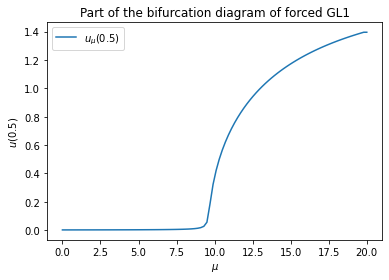

In [5]:
def forcing_fGL1(u, size, mu):
    return linGL1(size) @ u  + mu * (u  - u ** 3 / 3) + np.sin(np.pi * np.linspace(0, 1, size)) / 100

def zero_of_forcing_GL1(u0, size, mu):
    tol = 1e-6
    max_iter = 200
    l_fGL1 = lambda u: forcing_fGL1(u, size, mu)
    l_JacGL1 = lambda u: JacGL1(u, size, mu)
    return newton(u0, l_fGL1, l_JacGL1, tol, max_iter)

def forcing_cont(mu, u0, mu_end, steps):
    size = len(u0)
    mu_steps = np.linspace(mu, mu_end, steps)
    res = np.zeros((steps, size))
    res[0, :] = zero_of_forcing_GL1(u0, size, mu_steps[0])
    for step in range(1, steps):
        # Use the previous estimate as the new starting point
        res[step, :] = zero_of_forcing_GL1(res[step - 1], size, mu_steps[step])
    return res

size = 100

mu_end = 20
steps = 100
u05 = np.zeros(steps)

mu_pts = np.linspace(0, mu_end, steps)
data = forcing_cont(0, np.zeros(size), mu_end, steps)
    
for step in range(0, steps):
    u05[step] = data[step, 50]
        
plt.plot(mu_pts, u05, label='$u_\mu (0.5)$')
plt.xlabel('$\mu$')
plt.ylabel('$u(0.5)$')
plt.title('Part of the bifurcation diagram of forced GL1')
plt.legend()